# Interactive tutorial: extracellular electrical stimulation

## Objectives:
- Develop a **biophysical understanding** of the driving forces mediating the **excitation of neurons** upon exposure to **extracellular electrical fields**.
- Understand the concept of **activating function** as a predictor of neural excitability
- Gain an **intuitive insight** of the **impact of various features on neural excitability**, namely:
    - *current polarity and intensity*
    - *pulse duration*
    - *electrode-fiber relative positioning*
    - *fiber morphology*
    - *medium properties*

To study these concepts, we will again turn to *computational modeling*, which consitutes an optimal tool to dissect biophysical interactions.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget
from ipywidgets import Layout, FloatSlider, FloatLogSlider
from fibermodel import MyelinatedFiber
from medium import VolumeConductor
from stimulus import ExtracellularCurrentPulseTrain
from neuronsims import Simulation, copy_slider, interactive_display
from logger import logger

## Basic model components

We will start by modeling the 3 components composing our system of interest, namely:
- **a spatially extended neuron model**
- **an electrically conducting extracellular medium**
- **a point-source electrode delivering a stimulation current** 

As you have seen during the course, the electrical excitability of neural structures depends on multiple factors such as neuronal morphology and the spatial distribution of the induced extracellular potential around them.

These interactions can be difficult to interpret if we consider the complex 3D $(x, y, z)$ morphology of brain neurons. Therefore, we will leverage here a simplified system, made of a **peripheral axon segment running on a straight line in a nerve**. The morphological and geometrical simplicity of this system allows us to analyze stimulus-neuron interactions on a projected $(xz)$ plane, where $x$ is the direction of the axon and $z$ is the perpendicular direction.

### Axon model

We are going to use a double-cable, multi-compartment model of a myelinated axon as defined in [McIntyre et al. 2002](https://doi.org/10.1152/jn.00353.2001). Because it incorporates a highly realistic morphology of the spatially distributed neural membrane, this so-called *MRG model* is a consolidated biophysical model used to study the excitability of myelinated axons by electrical fields.

Note that this model is parameterized as a function of *axon diameter* and number of *nodes of Ranvier*, such that it can be used to model myelinated axons or arbitrary diameters and lengths.

We will start by defining a "typical" axon of 20 μm diameter and comprising 101 nodes. Knowing that internodal distance roughly equals 100 times the axon diameter, that corresponds to an axon length of about `100*100*20 = 200'000 μm = 20 cm`, which is more than enough to study local interactions around the axon's mid-point with little to no "edge" effects.

In [3]:
fiber = MyelinatedFiber(
    diameter=20,  # um
    nnodes=101
)
logger.info(f'fiber is {fiber.length / 1e4:.2f} cm long')

 23/02/2022 11:51:14: created MyelinatedFiber(20.0um, 101 nodes) model
 23/02/2022 11:51:14: fiber is 17.00 cm long


### Extracellular medium

To start with, we will model the extracellular medium as an isotropic volume conductor model with a conductivity corresponding to that of grey matter reported in [Hasgall et al. 2022](https://itis.swiss/virtual-population/tissue-properties/database/dielectric-properties/) (σ=0.56 S/m).

As a recall, for problems of involving frequencies < 3 kHz, it can be assumed that voltage distributions in the extracellular medium are purely governed by ohmic terms, i.e. that they *adapt intstantaneously to any change in current sources*. Under these circumstances, the electric potential $φ$ in the extracellular space is governed by Laplace’s equation:

$$∇ \cdot (σ∇φ) = 0$$

And for each punctual current source $I$ we then have:

$$σ∇φ = I$$

Assuming that extracellular conductivity is isotropic, the problem becomes spherically symmetric, yielding the following solution to the extracellular potential at a distance $r$ from the source:

$$φ(r) = \frac{I}{4πσr}$$

In [4]:
medium = VolumeConductor(sigma=0.56)

 23/02/2022 11:51:14: created IsotropicVolumeConductor(sigma=0.56S/m)


### Stimulus

To start with, we will consider the simple case of a point source electrode located 100 μm above the axon central node, injecting brief 100 μs pulses of cathodic current in the extracellular medium.

In [5]:
stim = ExtracellularCurrentPulseTrain(
    pos=(0., 0., 100.),  # um
    I=-10.,  # uA
    tpulse=.1,  # ms
    npulses = 2,
    PRF = 0.2,  # kHz
    tstart=2. # ms
)

 23/02/2022 11:51:14: created ExtracellularCurrentPulseTrain(I=-10.00uA, tpulse=0.1ms, npulses=2, PRF=0.20kHz, tstart=2.0ms)


The configuration of our system can be represented as:

![extra-stim-circuit](imgs/extra_stim_circuit.png)

Let's assemble all our model components into a simulation object:

In [6]:
sim = Simulation(fiber, medium, stim)

### Recall: the *activating function*

Throughout this tutorial, we will regularly refer to the concept of ***activating function*** in order to predict neural excitability under various conditions of extracellular electrical stimulation. As you have seen during the course, the activating function is defined as the *second spatial derivative of the extracellular potential along the neuron membrane*. In our simplified system, this relationship can be expressed as:

$$Ψ = \frac{d^2φ}{dx^2}$$

where $φ$ represents teh extracellular potential and $x$ is the axial position along the axon.

## Impact of stimulation polarity (cathodic vs anodic)

We will first investigate the impact of stimulation polarity on the excitability of our neuron model.

### Predictions
We will first have a look at how current polarity and intensity impact the activating function.

Output()

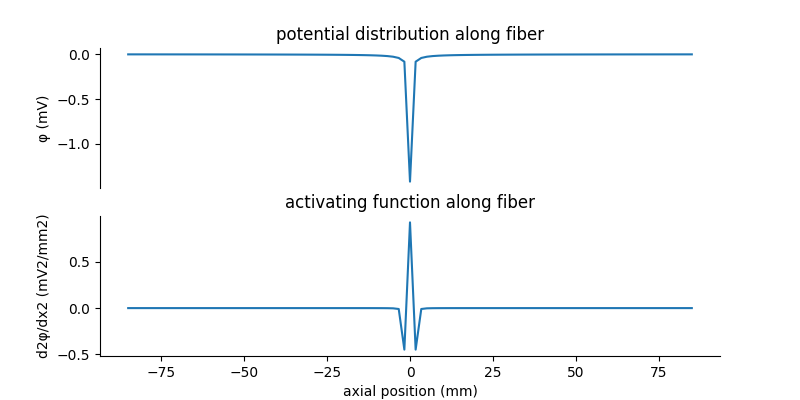

In [7]:
slider_layout = Layout(width='500px')
Islider = FloatSlider(
    description='I (uA)', min=-30, max=150, value=-1, step=5, continuous_update=False, layout=slider_layout)

def update(sim, I, **kwargs):
    sim.stim.I = I
    return sim.plot_profiles(**kwargs)

interactive_display(sim, update, Islider);

#### Questions:

- *What is the nature of the extracellular potential profile along the axon?*
- *What is the nature of the activating function profile along the axon?*
- *How are those profiles affected by the current intensity and polarity?* 
- *Based on the profiles of the activating function, where do you expect the axon to be excited for cathodic stimuation ($I < 0$)? And for anodic stimulation ($I> 0$)?*
- *Based on these results, what type of stimulation (cathodic or anodic) will be more efficient?*

### Simulations

Let's verify the predictions formulated above by performing full-fledged simulations our our system.

 23/02/2022 11:51:55: simulating MyelinatedFiber(20.0um, 101 nodes) stimulation by ExtracellularCurrentPulseTrain(I=-1.00uA, tpulse=0.1ms, npulses=2, PRF=0.20kHz, tstart=2.0ms)...


Output()

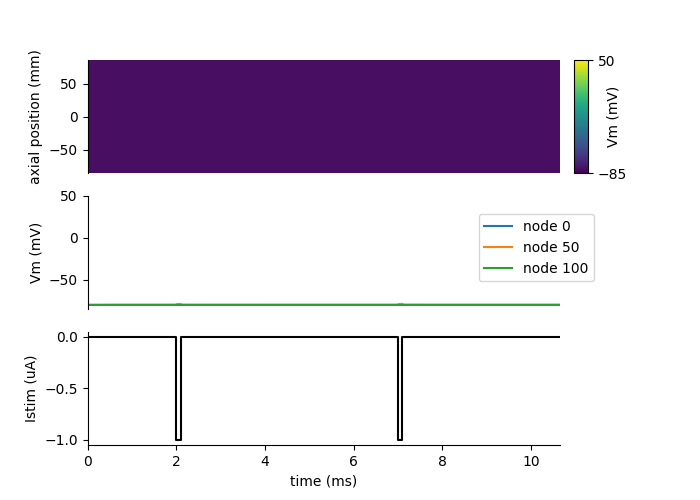

In [8]:
def update(sim, I, **kwargs):
    sim.stim.I = I
    tvec, vnodes = sim.run()
    return sim.plot_results(tvec, vnodes, **kwargs)

interactive_display(sim, update, Islider);

#### Questions:

- *What is the minimum current required to trigger an action potential with an **anodic** source? And with a **cathodic** source?*
- *At which locations is the axon initially excited with **cathodic** stimulation? And with **anodic** stimulation?*
- *How do these observations compare to predictions of the activating function?*

## Impact of pulse duration

Now that we've established how and why cathodic stimulation is a the more efficient extracellular stimulation polarity, let's analyze the impact of the pulse duration on neural excitability.

Because the pulse duration is not directly related with the spatial features of our system, its impact cannot be predicted through the prism of the activating function. Hence we will analyze it by simply running simulations of our system.

 23/02/2022 11:52:07: simulating MyelinatedFiber(20.0um, 101 nodes) stimulation by ExtracellularCurrentPulseTrain(I=-1.00uA, tpulse=0.1ms, npulses=2, PRF=0.20kHz, tstart=2.0ms)...


Output()

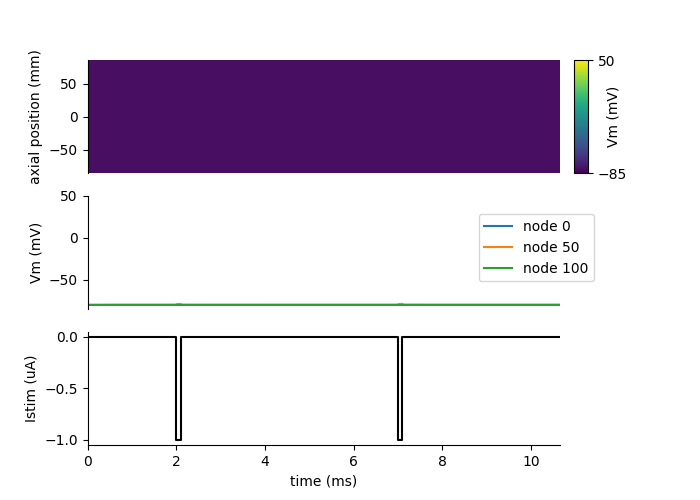

In [9]:
Islider2 = copy_slider(Islider, min=-70, max=0, step=1)
PWslider = FloatLogSlider(
    description='PW (ms)', base=10, min=-2, max=1, value=0.1, step=0.2, continuous_update=False, layout=slider_layout)

def update(sim, I, PW, **kwargs):
    sim.stim.I = I
    sim.stim.tpulse = PW
    tvec, vnodes = sim.run()
    return sim.plot_results(tvec, vnodes, **kwargs)

interactive_display(sim, update, Islider2, PWslider);

#### Questions:

- *Using a cathodic source, what is the excitation threshold current for pulses of a 10 μs long pulse? What about 100 μs, 1 ms, 5 ms?*
- *What can you say about the evolution of the threshold excitation current as a function of pulse duration?*
- *Which theoretical concept does that illustrate?*

## Impact of electrode-axon distance

Beyond the core characteristics of the stimulus, neural excitability is obviously impacted by the geometrical arrangement between the current source (the electrode) and the neural target (the axon). We will analyze here the impact of electrode-axon distance on excitation thresholds in our simplified system. 

### Predictions
We will first have a look at electrode-neuron distance impacts the activating function.

Output()

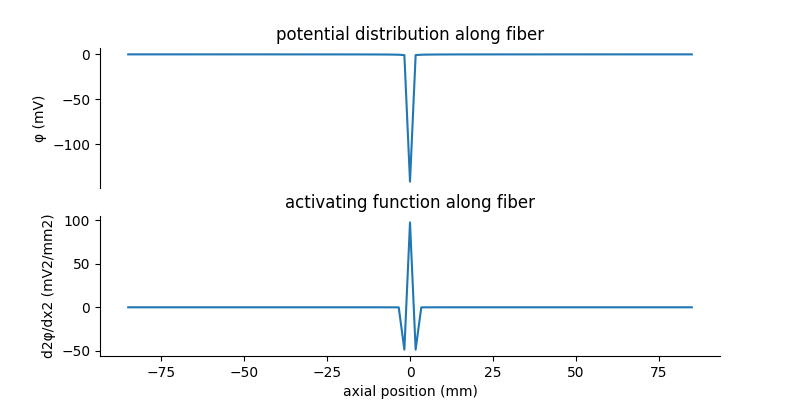

In [10]:
DZslider = FloatLogSlider(
    description='Δz (um)', base=10, min=0.8, max=3, value=10., step=0.2, continuous_update=False, layout=slider_layout)

def update(sim, dz, **kwargs):
    sim.stim.pos = (0., 0., dz)
    return sim.plot_profiles(**kwargs)

interactive_display(sim, update, DZslider);

#### Questions

- *How does electrode-axon distance impact the extracellular voltage profile along the axon?*
- *What about the impact on the activating function?*
- *Based on these results, do you expect excitation thresholds to increase or decrease as the electrode-axon distance increases?*

### Simulations

Let's verify the predictions formulated above by performing full-fledged simulations our our system.

 23/02/2022 11:52:59: simulating MyelinatedFiber(20.0um, 101 nodes) stimulation by ExtracellularCurrentPulseTrain(I=-1.00uA, tpulse=0.1ms, npulses=2, PRF=0.20kHz, tstart=2.0ms)...


Output()

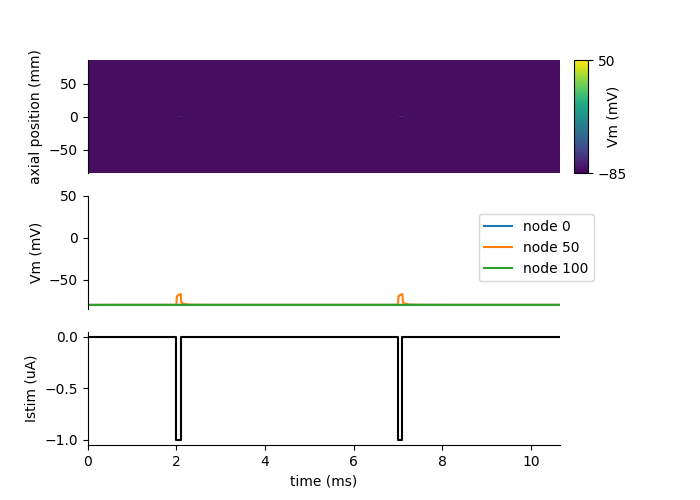

In [11]:
Islider3 = copy_slider(Islider2, min=-300)
def update(sim, I, dz, **kwargs):
    sim.stim.I = I
    sim.stim.pos = (0., 0., dz)
    sim.rel_phis = sim.get_phi(sim.fiber.xsections)
    tvec, vnodes = sim.run()
    return sim.plot_results(tvec, vnodes, **kwargs)

interactive_display(sim, update, Islider3, DZslider);

### Questions:

- *Using a cathodic source, what is the excitation threshold current for an electrode located 10 μm away from the axon? What about 100 μm, 1 mm?*
- *What can you say about the evolution of the threshold excitation current as a function of electrode-axon distance?*
- *How do these observations compare to predictions of the activating function?*

## Impact of medium conductivity

Beyond the electrode-neuron geometrical arrangement, extracellular voltage distributions and the resulting neural excitability are also impacted by the **medium's dielectric properties**. In particular, for quasi-static problems ($f < 3 kHz$), the electrical field redistribution inside the medium is governed by its electrical conductivity σ, which varies significantly in amplitude and anisotropy across brain regions. 

We will analyze here the impact of the medium electrical conductivity on neural excitability on our simplified system. 

### Predictions
We will first have a look at how medium conductivity impacts the activating function.

Output()

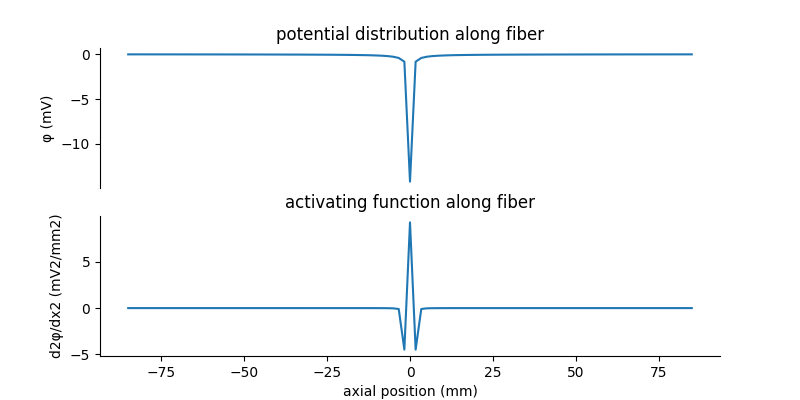

In [14]:
sigmaslider = FloatLogSlider(
    description='σ (S/m)', base=10, min=-1, max=1, value=.56, step=0.2, continuous_update=False, layout=slider_layout)

def update(sim, sigma, **kwargs):
    sim.medium.sigma = sigma
    return sim.plot_profiles(**kwargs)

interactive_display(sim, update, sigmaslider);

#### Questions

- *What is the impact of medium conductivity on the profile of extracellular voltage along the axon?*
- *What about its impact on the activating function?*
- *Based on these results, do you expect excitation thresholds to increase or decrease as the medium conductivity increases?*

### Simulations

Let's verify the predictions formulated above by performing full-fledged simulations our our system.

 23/02/2022 11:54:56: simulating MyelinatedFiber(20.0um, 101 nodes) stimulation by ExtracellularCurrentPulseTrain(I=-1.00uA, tpulse=0.1ms, npulses=2, PRF=0.20kHz, tstart=2.0ms)...


Output()

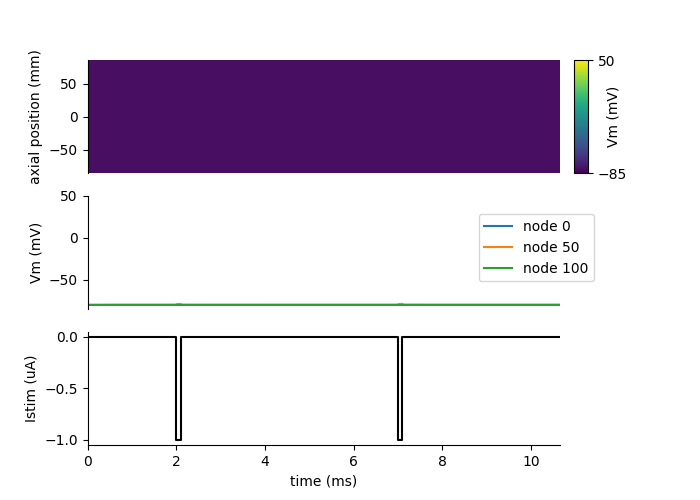

In [15]:
def update(sim, I, sigma, **kwargs):
    sim.stim.I = I
    sim.medium.sigma = sigma
    sim.rel_phis = sim.get_phi(sim.fiber.xsections)
    tvec, vnodes = sim.run()
    return sim.plot_results(tvec, vnodes, **kwargs)

interactive_display(sim, update, Islider2, sigmaslider);

### Questions:

- *Using a cathodic source, what is the excitation threshold current for a medium conductivity of 1 S/m? What about 10 S/m?*
- *What can you say about the evolution of the threshold excitation current as a function of medium conductivity?*
- *How do these observations compare to predictions of the activating function?*

## Impact of morphology

Beyond stimulus parameters, electrode-neuron relative positioning and medium properties, we also know from empirical observations that neuronal morphology (i.e. the structure and spatial distribution of the different parts of a neuron) greatly impacts excitability by electrical fields.

In our simplified system, we can analyze this impact by varying the axon outer diameter and assessing the resulting changes on excitation thresholds.

 23/02/2022 11:57:16: simulating MyelinatedFiber(10.0um, 101 nodes) stimulation by ExtracellularCurrentPulseTrain(I=-1.00uA, tpulse=0.1ms, npulses=2, PRF=0.20kHz, tstart=2.0ms)...


Output()

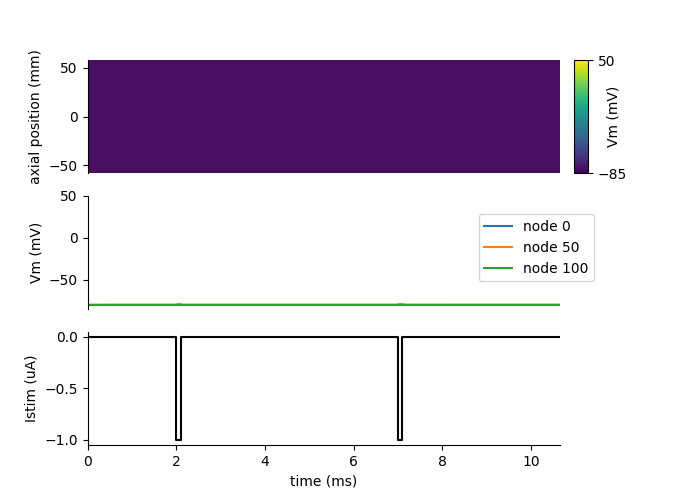

In [18]:
dslider = FloatSlider(
    description='diam (μm)', min=3, max=20, value=10, step=1, continuous_update=False, layout=slider_layout)

def update(sim, I, d, **kwargs):
    sim.stim.I = I
    sim.fiber.diameter = d
    sim.rel_phis = sim.get_phi(sim.fiber.xsections)
    tvec, vnodes = sim.run()
    return sim.plot_results(tvec, vnodes, **kwargs)

interactive_display(sim, update, Islider2, dslider);

### Questions:

- *Using a cathodic source, what is the excitation threshold current for a myelinated axon of 5 μm outer diameter? What about 10 μm, 20 μm?*
- *What can you say about the evolution of the threshold excitation current as a function of axon outer diameter?*
- *How does this trend compare to the natural recruitment order of neural fibers?*

## Conclusions

This tutorial should have given you a good intuition of the impact of the following features on neural excitability:
- **current polarity and intensity**
- **electrode-fiber relative positioning**
- **fiber morphology**
- **medium properties**